In [1]:
# important imports for this notebook
from absl import logging
import flax
import jax.numpy as jnp
import jax
from matplotlib import pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

import optax
from flax.training import train_state
from flax.metrics import tensorboard

tf.config.experimental.set_visible_devices([], "GPU")

logging.set_verbosity(logging.INFO)

2024-06-03 13:17:58.644685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 13:17:58.644739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 13:17:58.645540: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-03 13:17:59.293661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1:], 'GPU')
logical_devices = tf.config.list_logical_devices('GPU')
logical_devices

2.15.0


[]

In [2]:
# make sure we are on GPU
from jax.lib import xla_bridge

print(xla_bridge.get_backend().platform)

gpu


In [3]:
# Load in a dataset - start with mnist

# These commands break up the load command into it's parts for more controls
ds_builder = tfds.builder('cifar10')
ds_builder.download_and_prepare()
# 60000 training samples - no shuffle, no batch causes this to return a tensor of
# all of the data instead of a tensorflow dataset structure - we won't use tf.data
# here and just want to convert to numpy - these return dictionaries
train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))

# convert to 0 - 1 range for neural network training - don't want an arbitrary weight
# which could cause large gradients and difficult training.
train_ds['image'] = np.float32(train_ds['image']) / 255.0
test_ds['image'] = np.float32(test_ds['image']) / 255.0

INFO:absl:Load dataset info from /home/don/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/home/don/tensorflow_datasets/cifar10/3.0.2)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/don/tensorflow_datasets/cifar10/3.0.2.
INFO:absl:Constructing tf.data.Dataset cifar10 for split train, from /home/don/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/don/tensorflow_datasets/cifar10/3.0.2.
INFO:absl:Constructing tf.data.Dataset cifar10 for split test, from /home/don/tensorflow_datasets/cifar10/3.0.2


In [3]:
train_ds['image'][0].shape

(28, 28, 1)

In [4]:
test_ds

{'image': array([[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         ...,
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]],
 
 
        [[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ..

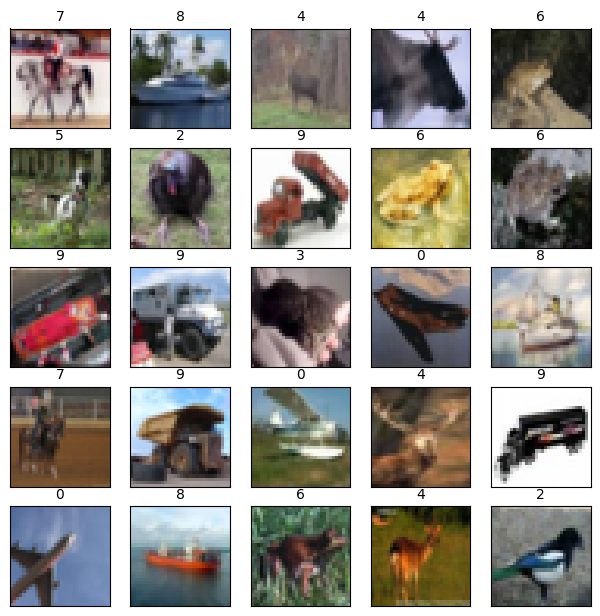

In [4]:
# Always good to check the data to make sure it loaded in properly
# Helper functions for images.

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img)
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title, fontsize=10)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(1.5 * n, 1.5 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)

show_img_grid(
    [train_ds['image'][idx] for idx in range(25)],
    [f'{train_ds["label"][idx]}' for idx in range(25)],
)
     

In [ ]:
%load_ext tensorboard
%tensorboard --logdir='flax_runs'

Launching TensorBoard...

In [50]:
# set up a convolutional model for image data in flax
from flax import linen as nn
from functools import partial

class CNN(nn.Module):
     # dtype for fp16/32 training
    dtype = jnp.float32

    @nn.compact
    def __call__(self, x, training: bool):
        norm = partial(
            nn.BatchNorm,
            use_running_average=not training,
            momentum=0.1,
            epsilon=1e-5,
            dtype=self.dtype,
        )
         
        # this is like the sequential model from Haiku
        x = nn.Conv(features=16, kernel_size=(3, 3), dtype=self.dtype)(x)
        x = norm()(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=32, kernel_size=(3, 3), dtype=self.dtype)(x)
        x = norm()(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=32, kernel_size=(3, 3), dtype=self.dtype)(x)
        x = norm()(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=0.5, deterministic=not training)(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = x.reshape((x.shape[0], -1)) #flatten the outputs
        x = nn.Dense(features=256, dtype=self.dtype)(x)
        x = norm()(x)
        x = nn.relu(x)

        # Need 10 output logits (1 per number) - thesse are assumed
        # to be log(probabilites) and will be fed into a softmax
        # layer at evaluation time. the softmax could also be placed
        # here
        x = nn.Dense(features=10, dtype=self.dtype(x))
        
        return x

In [71]:
# test the model
batch_size = 128
learning_rate = 0.01

rng = jax.random.key(0)

model = CNN()

batch = jnp.ones([1, 32, 32, 3])

rng, init_rng = jax.random.split(rng)

# initialize the model (i.e. generate random weights / parameters )
variables = model.init(init_rng, batch, training=False)
params = variables['params']
batch_stats = variables['batch_stats']

rng, dropout_key = jax.random.split(rng)

# params has to go in a kwarg
y, updates = model.apply({'params': params, 'batch_stats': batch_stats}, batch, training=True, rngs={'dropout': dropout_key}, mutable=['batch_stats'])

In [77]:
updates

{'batch_stats': {'BatchNorm_0': {'mean': Array([-0.60474557, -0.05222587, -0.58536613,  0.07746065,  2.044389  ,
          -0.3499031 , -1.8940983 ,  0.67038715,  0.01209099, -0.57270116,
          -0.38500175, -1.070415  ,  0.723007  , -0.16959998, -0.6744903 ,
           1.1131309 ], dtype=float32),
   'var': Array([0.10880068, 0.15709704, 0.10788489, 0.12112909, 0.15586762,
          0.13172248, 0.18307766, 0.13766347, 0.11843514, 0.13899082,
          0.10442536, 0.16361588, 0.12526877, 0.13156246, 0.13952096,
          0.12056214], dtype=float32)},
  'BatchNorm_1': {'mean': Array([-0.07645293,  0.27979177, -0.14588507,  0.24443227,  0.19544742,
          -0.10376288,  0.04273626,  0.0576426 ,  0.0543759 , -0.09298666,
          -0.3086567 ,  0.1718026 ,  0.29465893, -0.10053395, -0.10843628,
           0.36203995,  0.22073732,  0.17642821,  0.07192171,  0.17020983,
          -0.14380352, -0.11709127, -0.07478129, -0.02810775, -0.16840114,
          -0.30787054,  0.24991363, -0.055

In [79]:
print(model.tabulate(jax.random.key(0), jnp.ones((32, 32, 32, 3)), training=True,
                   compute_flops=True, compute_vjp_flops=True))

TypeError: Value Dense(
    # attributes
    features = 10
    use_bias = True
    dtype = Traced<ShapedArray(float32[32,256])>with<DynamicJaxprTrace(level=1/0)>
    param_dtype = float32
    precision = None
    kernel_init = init
    bias_init = zeros
    dot_general = None
    dot_general_cls = None
) with type <class 'flax.linen.linear.Dense'> is not a valid JAX type

In [46]:
# We need a function to apply the gradients to the model, which will
# update the parameters - can be used to update the model, or we 
# can ignore the gradients and calculate stats for the test set
@jax.jit
def apply_model(state, images, labels, dropout_key):
    dropout_train_key = jax.random.fold_in(key=dropout_key, data=state.step)
    def loss_fn(params, batch_stats):
        logits, updates = state.apply_fn({'params': params, 'batch_stats': batch_stats}, images, training=True, rngs={'dropout': dropout_train_key}, mutable=['batch_stats'])
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, (logits, updates)
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, accuracy

@jax.jit
def apply_model_test(state, images, labels, dropout_key):
    dropout_train_key = jax.random.fold_in(key=dropout_key, data=state.step)
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, images, training=False, rngs={'dropout': dropout_train_key})
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, accuracy

In [47]:
# simulate one training run
# initialize optax with a particular training algorithm
from typing import Any

tx = optax.adam(learning_rate=learning_rate)

class TrainState(train_state.TrainState):
  key: jax.Array
  batch_stats: Any

# we then store the state of the training (current parameters, state of optax, and the function to apply)
state = TrainState.create(apply_fn=model.apply, params=params, tx=tx, key=dropout_key, batch_stats=batch_stats)

train_ds_size = len(train_ds['image'])
# Once we have a random permutation of data, this is how many times we 
# will need ot divide it up to get the required batches
steps_per_epoch = train_ds_size // batch_size

# Get a random permutation
perms = np.random.permutation(len(train_ds['image']))
perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
perms = perms.reshape((steps_per_epoch, batch_size))

# So perms will just be a list of indcies into the original training dataset

# This is what one batch of the permutation looks like then
batch_images = train_ds['image'][perms[0], ...]
batch_labels = train_ds['label'][perms[0], ...]

# 1 - apply model - apply the model to the current batch images, get the logits,
# get the loss, and calculate the gradients over the current batch
grads, loss, accuracy = apply_model(state, batch_images, batch_labels, dropout_key=state.key)

# 2 - apply the gradients to update the parameters and then update the state 
# variable (it will internally keep track of the step number)
state = state.apply_gradients(grads=grads)

# 3 - now we could do it all over again

In [43]:
batch_images.shape

(128, 32, 32, 3)

In [48]:
# then we can put this into a full training loop - this is 1 epoch, i.e. 
# one full run through all of the distinct data. Generally you will need 
# to run many epochs to fully train a network though.
num_epochs = 25

for epoch in range(1, num_epochs + 1):
    epoch_loss = []
    epoch_accuracy = []

    rng, input_rng = jax.random.split(rng)

    # We should log the data somehow. Tensorflow is the standard for this, but
    # we should incorporate the clu tools next
    #summary_writer = tensorboard.SummaryWriter('./models/test1')
    # We can add some descriptive hyperparameters for each test
    # This should obviously go into some kind of config library, of which many 
    # exist for this application
    #summary_writer.hparams({'optimzier': 'adam', 'learning_rate': learning_rate, 'epochs': num_epochs, 'batch_size': batch_size})

    train_ds_size = len(train_ds['image'])
    # Once we have a random permutation of data, this is how many times we 
    # will need ot divide it up to get the required batches
    steps_per_epoch = train_ds_size // batch_size

    # Get a random permutation
    perms = np.random.permutation(len(train_ds['image']))
    perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    # So perms will just be a list of indcies into the original training dataset

    for perm in perms:
        batch_images = train_ds['image'][perm, ...]
        batch_labels = train_ds['label'][perm, ...]

        grads, loss, accuracy = apply_model(state, batch_images, batch_labels, state.key)

        state = state.apply_gradients(grads=grads)

        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)

    train_loss = np.mean(epoch_loss)
    train_accuracy = np.mean(epoch_accuracy)

    # We should apply the model to the test set to get an unbiased metric
    _, test_loss, test_accuracy = apply_model_test(
        state, test_ds['image'], test_ds['label'], state.key
    )


    logging.info(
            'epoch:% 3d, train_loss: %.4f, train_accuracy: %.2f, test_loss: %.4f,'
            ' test_accuracy: %.2f'
            % (
                epoch,
                train_loss,
                train_accuracy * 100,
                test_loss,
                test_accuracy * 100,
            )
        )
    
    #summary_writer.scalar('train_loss', train_loss, epoch)
    #summary_writer.scalar('train_accuracy', train_accuracy, epoch)
    #summary_writer.scalar('test_loss', test_loss, epoch)
    #summary_writer.scalar('test_accuracy', test_accuracy, epoch)

    #summary_writer.flush()

INFO:absl:epoch:  1, train_loss: 1.7703, train_accuracy: 34.80, test_loss: 1.5125, test_accuracy: 43.81
INFO:absl:epoch:  2, train_loss: 1.5589, train_accuracy: 42.83, test_loss: 1.5018, test_accuracy: 45.59
INFO:absl:epoch:  3, train_loss: 1.4975, train_accuracy: 45.31, test_loss: 1.3794, test_accuracy: 48.96
INFO:absl:epoch:  4, train_loss: 1.4599, train_accuracy: 46.83, test_loss: 1.3470, test_accuracy: 50.65
INFO:absl:epoch:  5, train_loss: 1.4410, train_accuracy: 47.89, test_loss: 1.3423, test_accuracy: 51.46
INFO:absl:epoch:  6, train_loss: 1.4178, train_accuracy: 48.87, test_loss: 1.2614, test_accuracy: 54.17
INFO:absl:epoch:  7, train_loss: 1.3916, train_accuracy: 49.93, test_loss: 1.2259, test_accuracy: 55.38
INFO:absl:epoch:  8, train_loss: 1.3681, train_accuracy: 50.78, test_loss: 1.2403, test_accuracy: 55.22
INFO:absl:epoch:  9, train_loss: 1.3632, train_accuracy: 50.76, test_loss: 1.2804, test_accuracy: 54.69
INFO:absl:epoch: 10, train_loss: 1.3427, train_accuracy: 51.54, 

KeyboardInterrupt: 

In [18]:
type(batch_labels)

numpy.ndarray

In [ ]:
train_accuracy

0.14324078